In [8]:
import HelperReviewAnalysis as helper
import ReadData as rd
import pandas as pd
from pandas.io.json import json_normalize
from matplotlib import pyplot as plt

reviewFile="dataset/reviewShuffled.json"
businessFile="dataset/business.json"
userFile="dataset/user.json"

In [2]:
reviewdata=rd.readData(fileName=reviewFile,breakCondition=5000000)

Data Loaded
Total Data:  4736897


In [17]:
userdata=rd.readData(fileName=userFile,breakCondition=5000000)

Data Loaded
Total Data:  1183362


In [3]:
def getRestaurantBusinesses():
    bdata=rd.readData(fileName=businessFile,breakCondition=10000000)
    businessSet=[]
    bData=[]
    for b in bdata:
        bid,categoryList=b['business_id'],b['categories']
        if 'Restaurants' in categoryList:
            bData.append(b)
            businessSet.append(bid)
#     bdata=pd.DataFrame(bData,index=businessSet)
    return bData,businessSet

def getGeographicalRestaurants(bdata,businessSet,state="AZ"):
    bData=pd.DataFrame(bdata,index=businessSet)
    stateBusinesses=bData[bData.state==state]
    return stateBusinesses

def getRestaurantReviews(reviewdata,businessSet):
    businessSet=set(azData.business_id)    
    print("Data Loaded")
    data=[]
    for d in reviewdata:
        bid=d['business_id']
        if bid in businessSet:
            data.append(d)
    print(len(data))
    return data


In [4]:
bdata,businessSet=getRestaurantBusinesses()
len(bdata),len(businessSet)



Data Loaded
Total Data:  156639


(51613, 51613)

In [5]:
azData=getGeographicalRestaurants(bdata,businessSet,state="AZ")
# print(bdata[:1])
print(len(bdata),len(azData))

51613 10219


In [6]:
azData[:1]

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
duHFBe87uNSXImQmvBh87Q,4719 N 20Th St,"{'RestaurantsTableService': False, 'GoodForMea...",duHFBe87uNSXImQmvBh87Q,"[Sandwiches, Restaurants]",Phoenix,{},0,33.505928,-112.038847,Blimpie,,85016,10,4.5,AZ


In [15]:
azData['stars'].value_counts()

4.0    2574
3.5    2440
3.0    1827
2.5    1139
4.5    1093
2.0     618
1.5     234
5.0     222
1.0      72
Name: stars, dtype: int64

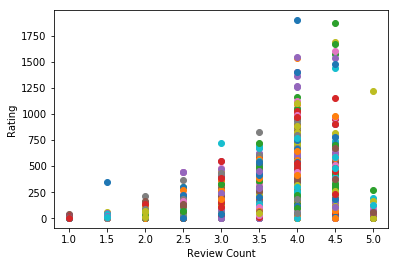

In [16]:
x,y = [],[]
y.append (azData.stars)
x.append (azData.review_count)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y,x,'o-')
ax.set_xlabel("Review Count")
ax.set_ylabel("Rating")
plt.show()


In [ ]:
data=getRestaurantReviews(reviewdata,azData)


In [ ]:
featDF=json_normalize(bdata)

In [ ]:
bIdMap=dict(zip(range(len(featDF)), businessSet))

In [ ]:
featDF=featDF.rename(bIdMap)
featDF=featDF[featDF.state=="AZ"]

In [ ]:
featDF[:100]

In [ ]:
def cleanFeatureMatrix(df):
    for d in df.columns:
        if 'hours' in d:
            df=df.drop([d],axis=1)
    df=df*1
    df=df.fillna(0)
    df=df.drop(['business_id','postal_code','city','categories','address','is_open','latitude','longitude','name','neighborhood','state'], axis=1)
    delColList=[]
#     for i in df.columns:
#         print(i)
    for d in df.columns:
        valList=[]
        for val in df[d].value_counts():
#         print("val= ",val)
            valList.append(int(val))
        valList.sort()
        valList.reverse()
        if valList[0]==0:
            delColList.append(d)
            break
        if len(valList)>1:
            num=valList[1]/valList[0]
#         print(num, " :num")
        if num<0.2:
            delColList.append(d)
#     break
    delColList=set(delColList)

    for d in df.columns:
        if d in delColList:
            df=df.drop([d],axis=1)
    oneHotList=['attributes.RestaurantsAttire','attributes.Alcohol','attributes.NoiseLevel','attributes.RestaurantsPriceRange2','attributes.WiFi']
   
        
    colList=[i for i in oneHotList if not i in delColList]
    df=pd.get_dummies(df,columns = colList )
    return df



In [ ]:
print(len(featDF))
featDF=cleanFeatureMatrix(featDF)
print(len(featDF))

In [ ]:
featDF[:10]

In [ ]:
trainData=data[:200000]
reviewDataDF=pd.DataFrame(trainData)

In [ ]:
azUsers=set(reviewDataDF.user_id.unique())

In [ ]:
azusersList=[]
uidList=[]
for u in userdata:
    uid=u['user_id']
    if uid in azUsers:
        azusersList.append(u)
        uidList.append(uid)
        

In [ ]:
userDataDF=pd.DataFrame(azusersList,uidList)

In [ ]:
userDataDF[:1]
# len(userDataDF),len(azUsers)

In [ ]:
trainData[:1]

In [ ]:
columnList=['biasTerm']+list(featDF.columns)
columnList.append('userAvgRating')
columnList.append('userReviewCount')
featMat=pd.DataFrame(columns=columnList)
featMat

In [ ]:
count=0
def feature(datum,featMat):
    global count
    bid,user_id=datum['business_id'],datum['user_id']
    feature=[1]
    feat=featDF.loc[bid]
    userAvgRating=userDataDF.loc[user_id]['average_stars']
    userReviewCount=userDataDF.loc[user_id]['review_count']
    f1=pd.Series([userAvgRating])
    feat=feat.append(f1)
    feat=feat.rename({0: userAvgRating})
    f2=pd.Series([userReviewCount])
    feat=feat.append(f2)
    feat=feat.rename({0: userReviewCount})
    count+=1
    if count%1000==0:
        print(count)
    feature+=list(feat)
#     print(feature)
    df = pd.DataFrame([feature], columns=columnList)
    featMat=featMat.append(df,ignore_index=True)
    return featMat


for d in trainData:
    featMat=feature(d,featMat)
# featMat[:10]

In [ ]:
featMat.to_csv("dataset/ArizonaFeatureMatrixDF.csv", encoding='utf-8', index=False)